**Задание**

Вам необходимо провести эксперименты по начальному обучению различных моделей и сравнить результаты.

In [ ]:
!pip install torchsummary

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import torchvision as tv
from torchvision import transforms
from torchsummary import summary
import torch
from torch import nn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
import pandas as pd

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 1) Возьмите датасет EMNIST из torchvision

In [ ]:
transoforms = tv.transforms.Compose([
    tv.transforms.Grayscale(3),
    tv.transforms.Resize((224, 224)),
    tv.transforms.ToTensor()
])
train_dataset = tv.datasets.EMNIST('.', train=True, transform=transoforms, download=True, split='mnist')
test_dataset = tv.datasets.EMNIST('.', train=False, transform=transoforms, download=True, split='mnist')

100%|██████████| 561753746/561753746 [00:06<00:00, 91445960.50it/s] 


Extracting ./EMNIST/raw/gzip.zip to ./EMNIST/raw


In [ ]:
#Делаем из переменных итераторы, которые делят датасет на батчи. Поставим batch_size = 16
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16)

In [ ]:
train_dataset.data.shape

torch.Size([60000, 28, 28])

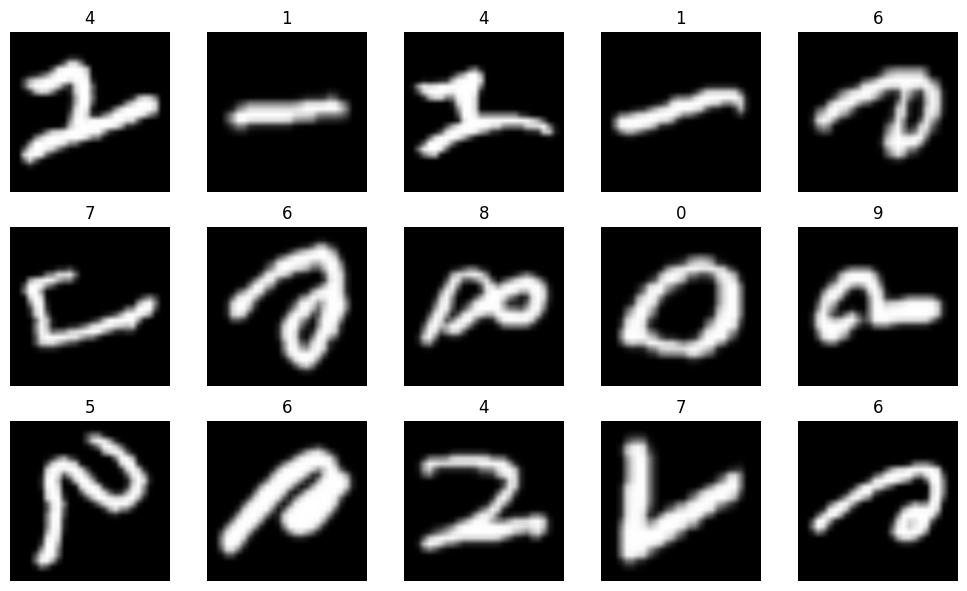

In [ ]:
rows, cols = 3, 5
num_images = rows * cols
transform_for_display = tv.transforms.Compose([tv.transforms.ToPILImage()])

# Создание новой фигуры для визуализации
fig = plt.figure(figsize=(10, 6))

for i in range(num_images):
    # Получение изображения и метки
    image, label = train_dataset[i]

    # Преобразование изображения в массив NumPy
    image = transform_for_display(image)

    # Добавление подграфа
    ax = fig.add_subplot(rows, cols, i + 1)

    # Отключение осей
    ax.axis('off')

    # Отображение изображения
    ax.imshow(image, cmap='gray')

    # Добавление подписи с классом
    ax.set_title(label)

# Вывод изображений
plt.tight_layout()
plt.show()


Проверим дисбаланс классов

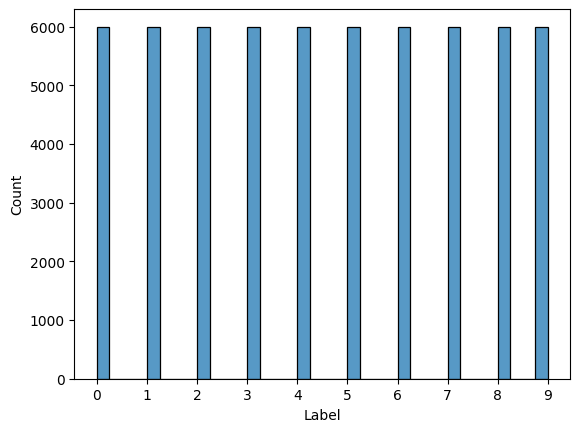

In [ ]:
labels = train_dataset.targets
sns.histplot(labels)
plt.xticks(range(10))
plt.xlabel('Label')
plt.show()

# 2) Обучите на нём модели: ResNet 18, VGG 16, Inception v3, DenseNet 161 (с нуля по 10 эпох)

In [ ]:
class Classifier:

    def __init__(self, learning_rate=0.03, num_epochs=10, device= device, model=None):
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.device = torch.device(device)
        self.model = model.to(self.device) if model is not None else None
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=self.learning_rate)
        self.train_loss = []
        self.test_loss = []
        self.train_accuracy = []
        self.test_accuracy = []

    def evaluate_accuracy(self, data_loader, net):
        acc_sum, n = 0, 0
        net.eval()
        for X, y in data_loader:
            X, y = X.to(self.device), y.to(self.device)
            acc_sum += (net(X).argmax(axis=1) == y).sum().item()
            n += y.shape[0]
        return acc_sum / n

    def evaluate_loss(self, data_loader, net):
        running_loss = 0.0
        for X, y in data_loader:
            X, y = X.to(self.device), y.to(self.device)
            outputs = self.model(X)
            loss = self.criterion(outputs, y)
            running_loss += loss.item()
        return round(running_loss/len(data_loader),4)

    def fit(self, train_loader, test_loader):
        for epoch in range(self.num_epochs):
            self.model.train()
            running_loss = 0.0
            start = time.time()

            for i, data in enumerate(train_loader, 0):
                inputs, labels = data
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item()
                print(f"\r{(int(i/len(train_loader)*100))+1}% ", end="", flush=True)

            self.train_loss.append(round(running_loss/len(train_loader), 4))
            loss_tst = self.evaluate_loss(test_loader, self.model)
            self.test_loss.append(loss_tst)

            test_acc = self.evaluate_accuracy(test_loader, self.model)
            train_acc = self.evaluate_accuracy(train_loader, self.model)
            self.train_accuracy.append(round(train_acc,3))
            self.test_accuracy.append(round(test_acc,3))


            print(f"Epoch: [{epoch+1}/{self.num_epochs}],Time: {time.time() - start:.1f}sec.,"
            f" Train loss:{running_loss/len(train_loader):.4f},Train accuracy: {train_acc:.3f},"
            f"Test loss : {loss_tst}, Test accuracy: {test_acc:.3f}")

            torch.cuda.empty_cache()

    def predict(self, test_loader):
        self.model.eval()
        predictions = []
        with torch.no_grad():
            for data in test_loader:
                inputs, _ = data
                inputs = inputs.to(self.device)
                outputs = self.model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                predictions.extend(predicted.cpu().numpy())
        return predictions


##ResNet-18

ResNet-18 (Residual Network-18) — это сверточная нейронная сеть, представляющая собой архитектуру глубокого обучения, разработанную для решения задач компьютерного зрения, таких как классификация изображений. Она была предложена в статье "Deep Residual Learning for Image Recognition" в 2015 году и считается одной из ключевых моделей, способствовавших прорыву в области глубокого обучения.

Основной инновацией в архитектуре ResNet-18 является использование блоков с остаточным соединением (residual connections), которые позволяют обучать гораздо глубокие сети без проблемы затухания градиентов. Это достигается путем добавления "skip connections" или "shortcut connections" внутри блоков, позволяя обходить несколько слоев и применять к результатам преобразований функцию идентичности. Таким образом, градиенты могут свободно проходить через эти блоки, даже при значительной глубине сети.

ResNet-18 состоит из 18 слоев, включая сверточные слои, пулинговые слои и полносвязные слои. Она начинается с одного сверточного слоя с большим числом фильтров (64 или 128) и последующим применением 4 блоков. Каждый блок включает два слоя, содержащих свертки с размерами 3x3 или 1x1, а также нормализацию и нелинейность. Блоки также могут изменять размер изображения при помощи пулинга или свертки.

ResNet-18 хорошо подходит для различных задач компьютерного зрения, таких как классификация изображений, детектирование объектов, семантическая сегментация и многие другие. Она достигает высокой точности даже при относительно небольшой глубине сети, благодаря использованию остаточных соединений, которые улучшают обучение и способствуют извлечению более информативных признаков из данных.


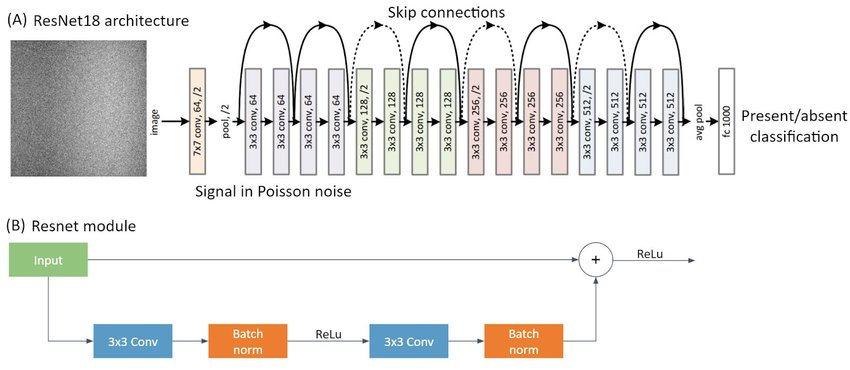

In [ ]:
model_ResNet18 = tv.models.resnet18(pretrained= False)

In [ ]:
model_ResNet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Изменим последний слой и обучим модель

In [ ]:
model_ResNet18.fc

Linear(in_features=512, out_features=1000, bias=True)

In [ ]:
model_ResNet18.fc = nn.Linear(in_features=512, out_features=10)

In [ ]:
summary(model_ResNet18.to(device), input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [ ]:
clf_resnet18 = Classifier(model = model_ResNet18)

In [ ]:
clf_resnet18.fit(train_loader, test_loader)

100% Epoch: [1/10],Time: 426.2sec., Train loss:0.1350,Train accuracy: 0.992,Test loss : 0.0391, Test accuracy: 0.991
100% Epoch: [2/10],Time: 427.0sec., Train loss:0.0310,Train accuracy: 0.996,Test loss : 0.0245, Test accuracy: 0.994
100% Epoch: [3/10],Time: 428.3sec., Train loss:0.0159,Train accuracy: 0.998,Test loss : 0.0197, Test accuracy: 0.995
100% Epoch: [4/10],Time: 429.7sec., Train loss:0.0080,Train accuracy: 0.999,Test loss : 0.0179, Test accuracy: 0.996
100% Epoch: [5/10],Time: 429.0sec., Train loss:0.0036,Train accuracy: 0.999,Test loss : 0.0176, Test accuracy: 0.995
100% Epoch: [6/10],Time: 414.5sec., Train loss:0.0013,Train accuracy: 1.000,Test loss : 0.0183, Test accuracy: 0.995
100% Epoch: [7/10],Time: 403.3sec., Train loss:0.0006,Train accuracy: 1.000,Test loss : 0.0182, Test accuracy: 0.995
100% Epoch: [8/10],Time: 423.4sec., Train loss:0.0004,Train accuracy: 1.000,Test loss : 0.0181, Test accuracy: 0.995
100% Epoch: [9/10],Time: 425.4sec., Train loss:0.0003,Train accu

In [ ]:
def Graph_metrics(model):

    los_tr = model.train_loss
    loss_tst = model.test_loss

    acc_tr = model.train_accuracy
    acc_tst = model.test_accuracy

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    ax1.plot(los_tr, label='Train loss', color='blue')
    ax1.plot(loss_tst, label='Test loss', color='red')
    ax1.set_title('Graph of changes in the loss function')
    ax1.grid()
    ax1.legend()


    ax2.plot(acc_tr, color='orange', label='Train accuracy')
    ax2.plot(acc_tst, color='green', label='Test accuracy')
    ax2.set_title('Graph of changes in the accuracy metric')
    ax2.grid()
    ax2.legend()

    plt.tight_layout()
    plt.show()

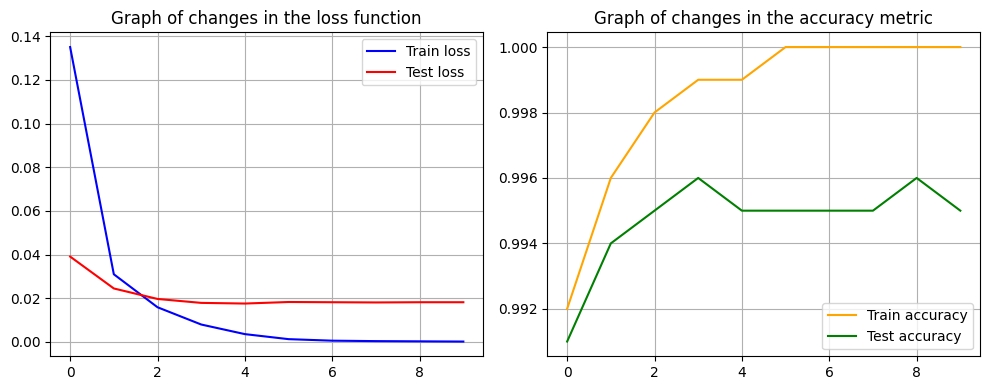

In [ ]:
Graph_metrics(clf_resnet18)

## VGG 16

VGG16 (Visual Geometry Group 16) - это архитектура сверточной нейронной сети, разработанная исследовательской группой Visual Geometry Group в Университете Оксфорд. VGG16 представляет собой глубокую сверточную нейронную сеть, которая стала одной из ключевых моделей в области компьютерного зрения после ее представления в 2014 году.

Основной особенностью архитектуры VGG16 является ее глубокость и однородность: сеть состоит из 16 сверточных и полносвязных слоев, включая сверточные слои с небольшим размером ядра 3x3, а также пулинговые слои. Отсюда и происходит название "VGG16".

Одна из важных идей VGG16 - использование многократных слоев с небольшими фильтрами вместо одного слоя с большим количеством фильтров. Это способствует улучшению выразительности сети и повышению ее способности извлекать абстрактные признаки из изображений.

Оригинальная архитектура VGG16 имеет следующее распределение слоев:

1. Сверточные слои: 13 слоев с фильтрами 3x3, последовательно увеличивающимися от 64 до 512 каналов.
2. Пулинговые слои: После каждых двух сверточных слоев, используется слой максимального пулинга для уменьшения размерности.
3. Полносвязные слои: Два полносвязных слоя с 4096 нейронами, а затем выходной слой с соответствующим количеством классов.

VGG16 была предварительно обучена на большом наборе изображений ImageNet, и ее обученные веса можно использовать как извлеченные признаки для различных задач компьютерного зрения, таких как классификация изображений, детектирование объектов и сегментация.

Хотя архитектура VGG16 считается важным вкладом в область глубокого обучения, она также достаточно тяжеловесная и имеет большое количество параметров, что может усложнить ее использование в ресурсоемких задачах.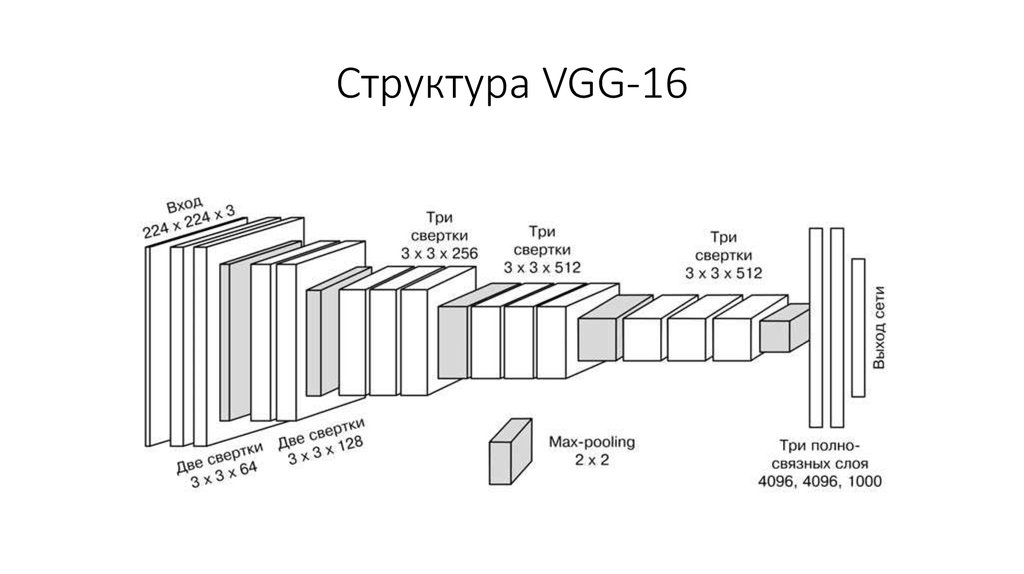

In [ ]:
model_VGG16 = tv.models.vgg16(pretrained= False)

In [ ]:
model_VGG16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
model_VGG16.classifier[6] = nn.Linear(in_features=4096, out_features=10)

In [ ]:
summary(model_VGG16.to(device), input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [ ]:
clf_VGG16 = Classifier(model = model_VGG16)

In [ ]:
clf_VGG16.fit(train_loader, test_loader)

100% Epoch: [1/10],Time: 1402.2sec., Train loss:0.2522,Train accuracy: 0.990,Test loss : 0.0424, Test accuracy: 0.990
100% Epoch: [2/10],Time: 1400.7sec., Train loss:0.0411,Train accuracy: 0.994,Test loss : 0.031, Test accuracy: 0.993
100% Epoch: [3/10],Time: 1400.1sec., Train loss:0.0273,Train accuracy: 0.995,Test loss : 0.0342, Test accuracy: 0.992
100% Epoch: [4/10],Time: 1396.4sec., Train loss:0.0204,Train accuracy: 0.996,Test loss : 0.0309, Test accuracy: 0.994
100% Epoch: [5/10],Time: 1398.3sec., Train loss:0.0163,Train accuracy: 0.998,Test loss : 0.0267, Test accuracy: 0.994
100% Epoch: [6/10],Time: 1400.8sec., Train loss:0.0137,Train accuracy: 0.998,Test loss : 0.0321, Test accuracy: 0.994
100% Epoch: [7/10],Time: 1398.0sec., Train loss:0.0101,Train accuracy: 0.999,Test loss : 0.0324, Test accuracy: 0.995
100% Epoch: [8/10],Time: 1398.2sec., Train loss:0.0099,Train accuracy: 0.999,Test loss : 0.0278, Test accuracy: 0.995
100% Epoch: [9/10],Time: 1398.9sec., Train loss:0.0070,Tr

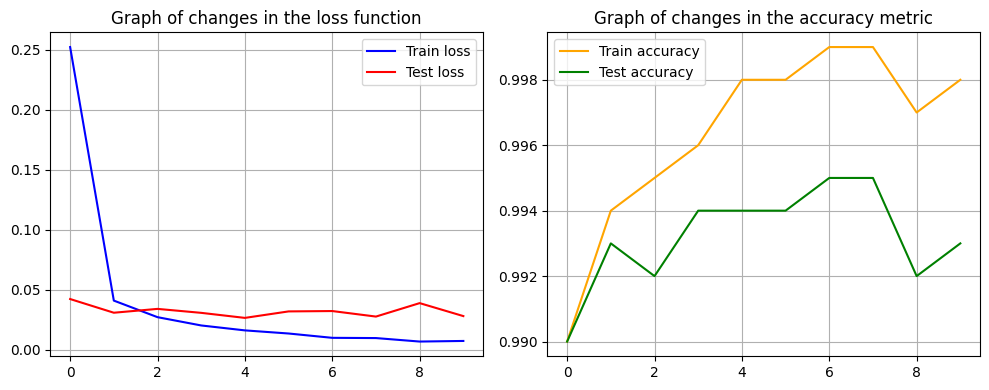

In [ ]:
Graph_metrics(clf_VGG16)

##DenseNet 161

**DenseNet-161** - это архитектура глубокой сверточной нейронной сети, которая была предложена в статье "Densely Connected Convolutional Networks" в 2017 году. Эта архитектура стала частью семейства сетей DenseNet (Densely Connected Convolutional Networks), которое известно своей эффективностью в использовании ресурсов и способностью обучать глубокие сети с меньшим количеством параметров.

Основной концепцией в архитектуре DenseNet является плотное соединение (dense connectivity) между слоями сети. Вместо того чтобы передавать информацию только от одного слоя к следующему, каждый слой получает входные данные от всех предыдущих слоев в блоке. Это позволяет сети эффективно использовать информацию о признаках, извлеченных на разных уровнях, и повышает стабильность обучения.

Архитектура DenseNet-161 состоит из нескольких блоков, называемых "Dense блоками", которые имеют плотное соединение между своими слоями. Каждый блок содержит несколько сверточных слоев, обычно состоящих из слоев с ядрами 3x3, их результаты объединяются и передаются на следующий блок. Это дает сети способность извлекать более сложные иерархические признаки на каждом последующем блоке.

Кроме того, в архитектуре DenseNet используется слой "бутлерных шейп-слоев" (bottleneck layers), который включает слой с ядром 1x1, который снижает количество каналов (фильтров), а затем слой с ядром 3x3. Это позволяет уменьшить вычислительную сложность и количество параметров, при этом сохраняя способность извлекать более сложные признаки.

В архитектуре DenseNet-161 также используется "пулинг среднего значения" (average pooling) для снижения размерности перед полносвязными слоями, что помогает уменьшить количество параметров и предотвратить переобучение.

Принцип работы DenseNet-161 заключается в эффективном использовании плотных соединений между слоями для создания более глубокой и более эффективной архитектуры, способной извлекать богатые иерархические признаки из изображений. Эта архитектура показывает высокую точность в задачах классификации изображений и детектирования объектов, даже при относительно небольшом количестве параметров.

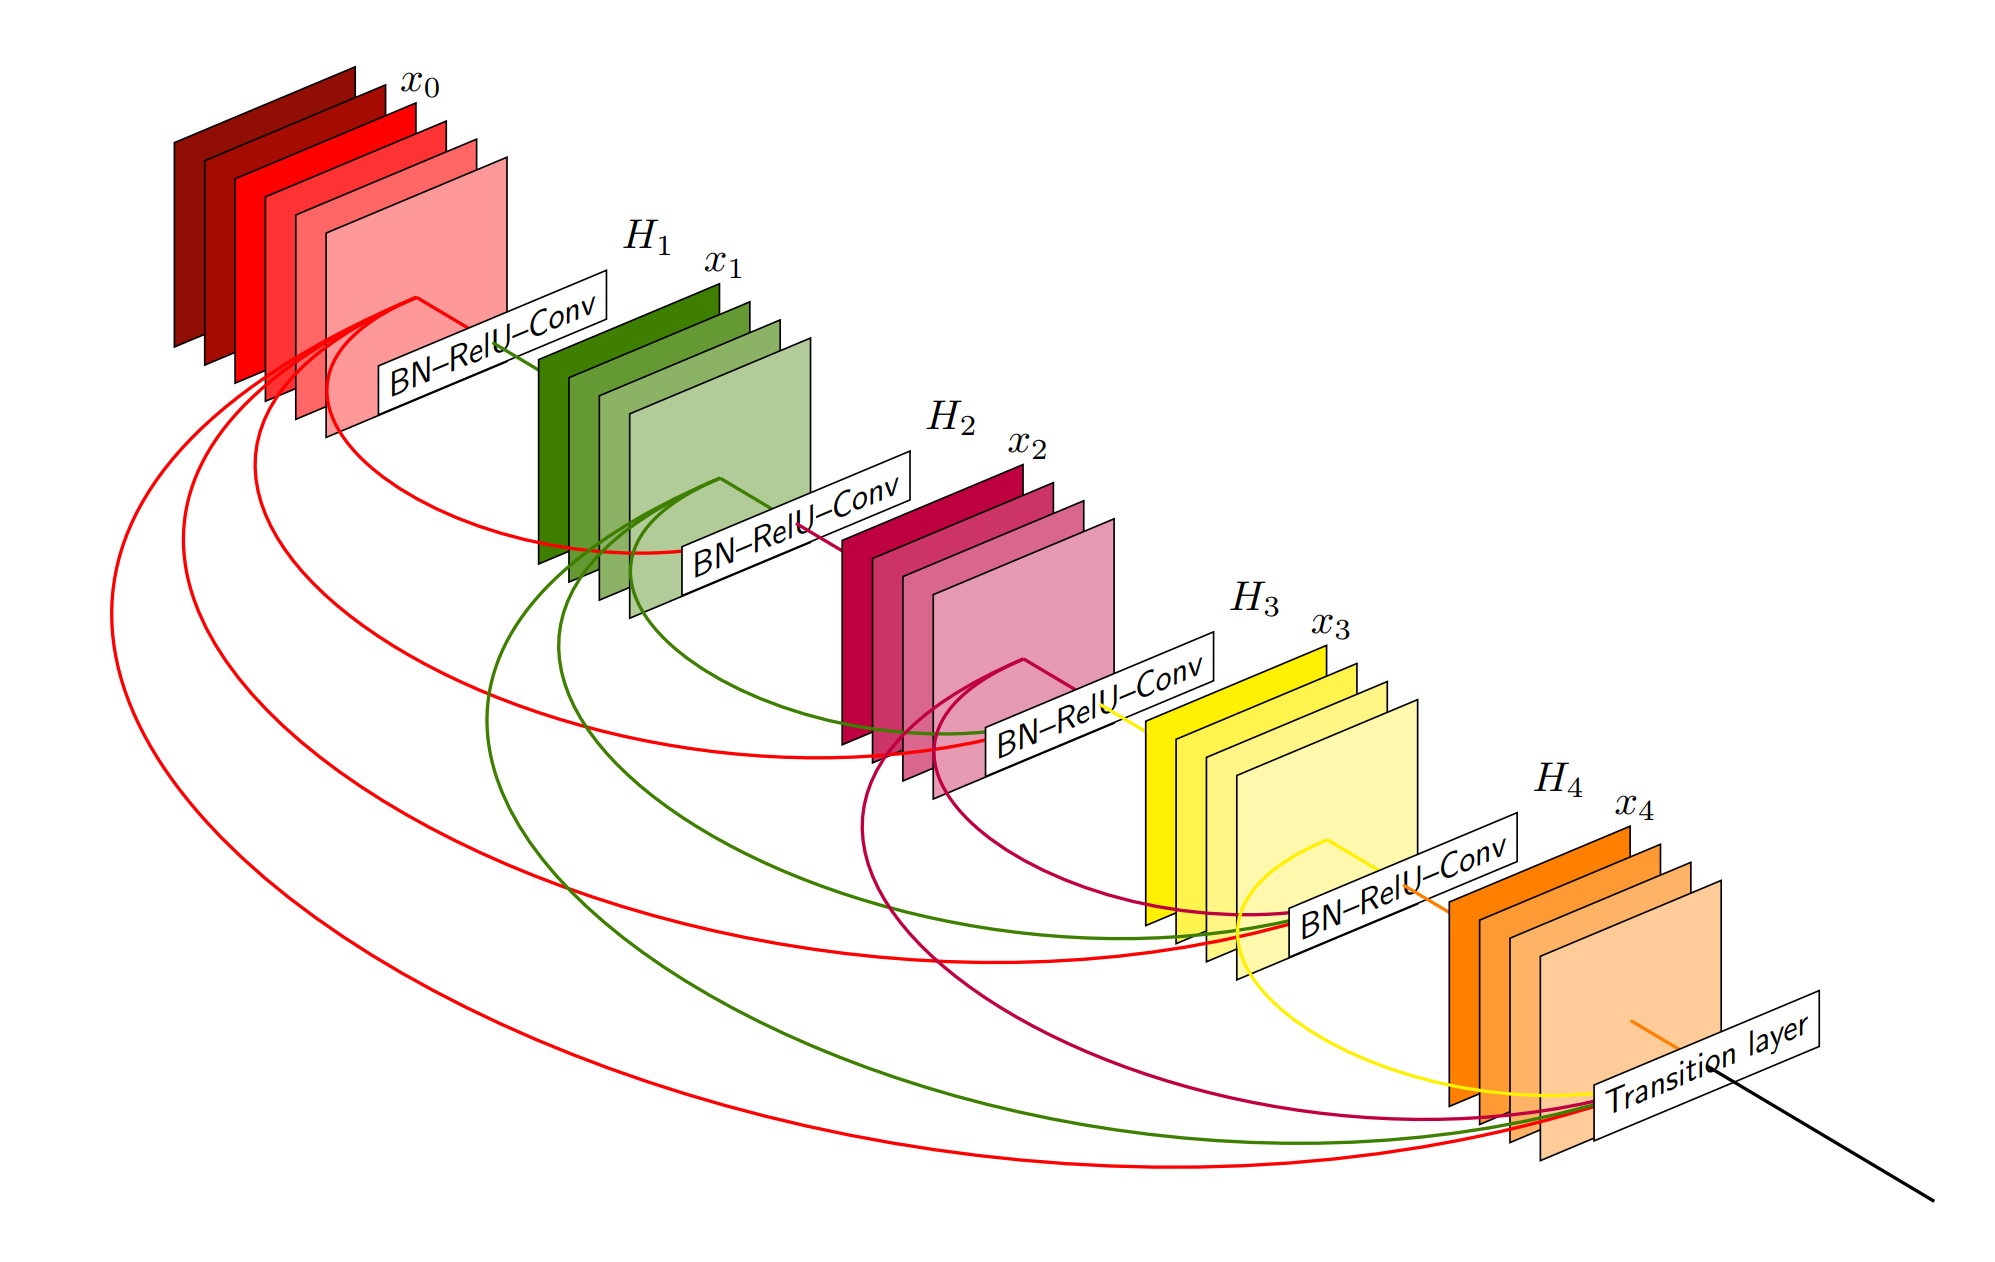



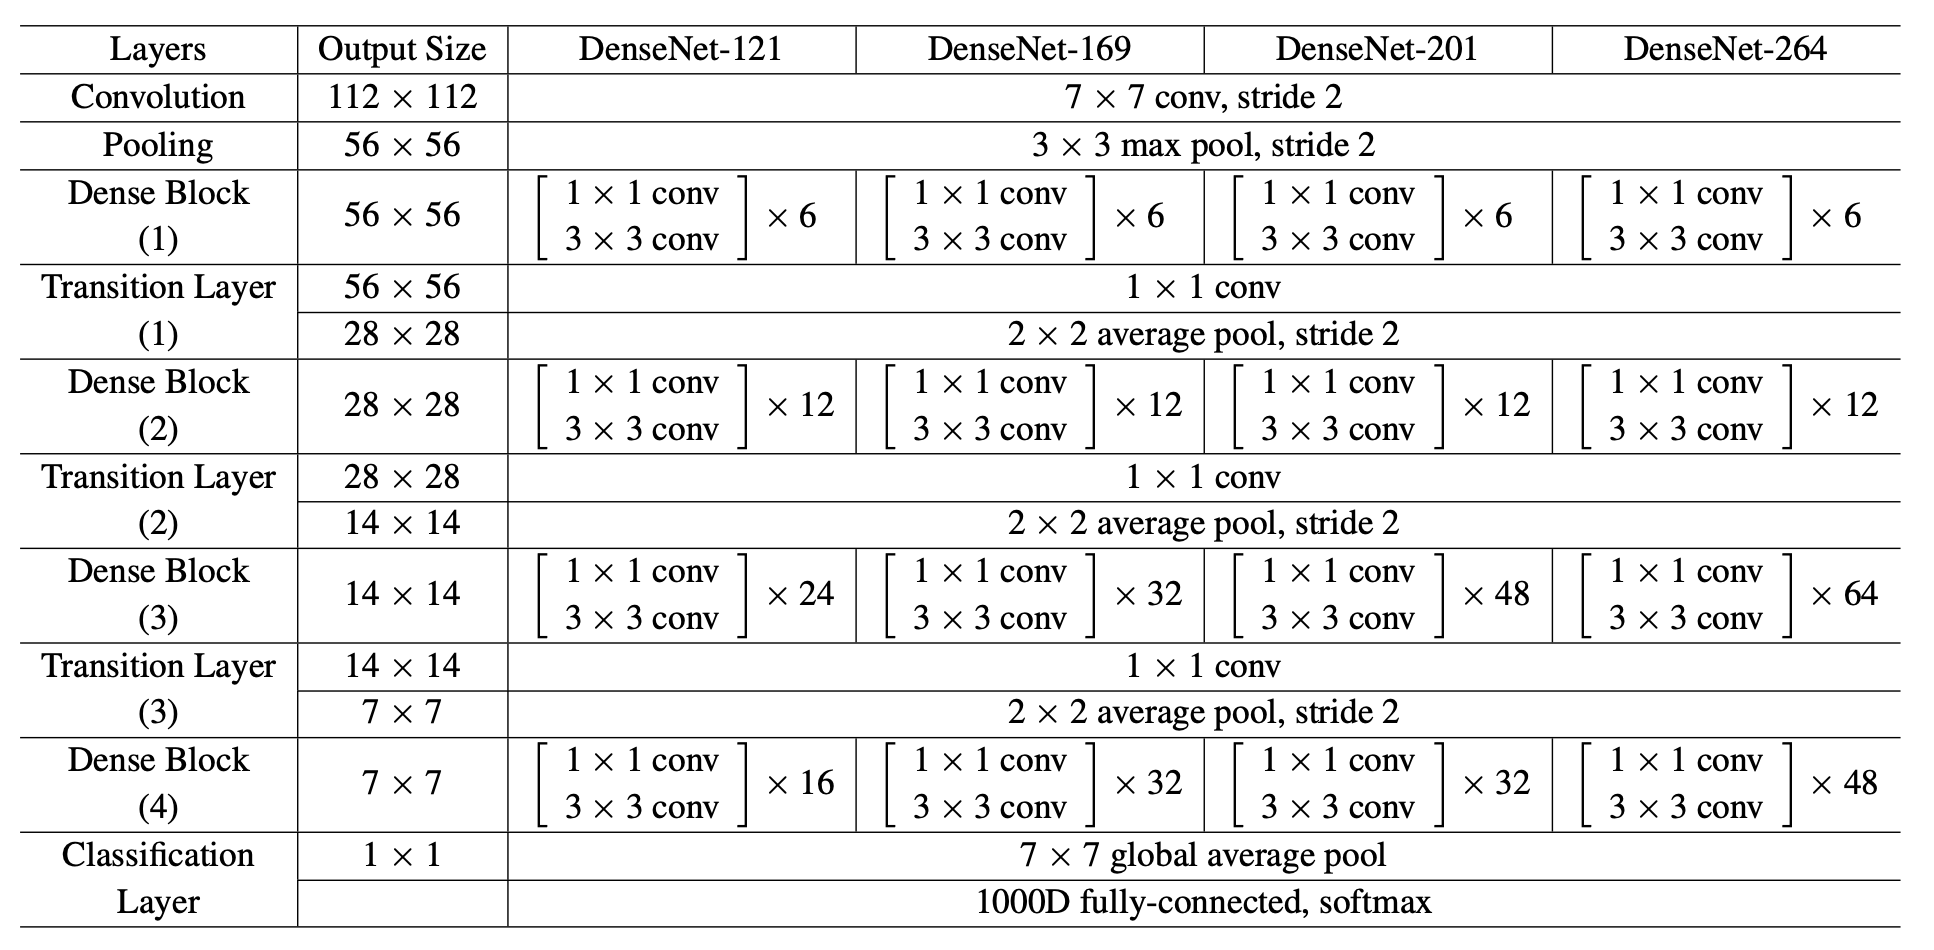

In [ ]:
model_densenet161 = tv.models.densenet161(pretrained= False)

In [ ]:
model_densenet161

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [ ]:
model_densenet161.classifier = nn.Linear(in_features=2208, out_features=10)

In [ ]:
clf_densenet161 = Classifier(model = model_densenet161)

In [ ]:
clf_densenet161.fit(train_loader, test_loader)

100% Epoch: [1/10],Time: 2024.8sec., Train loss:0.1615,Train accuracy: 0.993,Test loss : 0.0443, Test accuracy: 0.992
100% Epoch: [2/10],Time: 2025.0sec., Train loss:0.0347,Train accuracy: 0.995,Test loss : 0.0288, Test accuracy: 0.994
100% Epoch: [3/10],Time: 2028.0sec., Train loss:0.0189,Train accuracy: 0.997,Test loss : 0.0229, Test accuracy: 0.996
100% Epoch: [4/10],Time: 2019.8sec., Train loss:0.0095,Train accuracy: 0.998,Test loss : 0.0209, Test accuracy: 0.996
100% Epoch: [5/10],Time: 2017.2sec., Train loss:0.0046,Train accuracy: 0.999,Test loss : 0.0201, Test accuracy: 0.996
100% Epoch: [6/10],Time: 2016.8sec., Train loss:0.0021,Train accuracy: 0.999,Test loss : 0.0204, Test accuracy: 0.996
100% Epoch: [7/10],Time: 2019.0sec., Train loss:0.0009,Train accuracy: 1.000,Test loss : 0.0192, Test accuracy: 0.997
100% Epoch: [8/10],Time: 2019.7sec., Train loss:0.0005,Train accuracy: 1.000,Test loss : 0.0191, Test accuracy: 0.997
100% Epoch: [9/10],Time: 2018.4sec., Train loss:0.0003,T

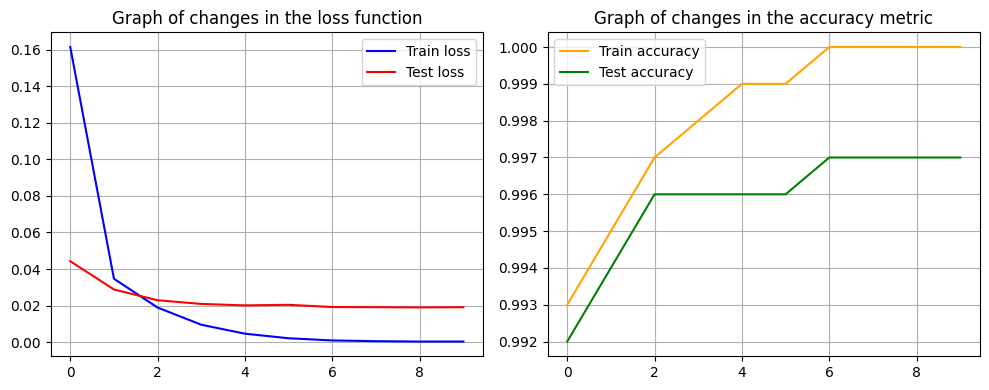

In [ ]:
Graph_metrics(clf_densenet161)

##Inception v3

Принцип работы Inception-v3 основан на идее эффективного объединения сверток разных размеров и архитектурных подходов в один слой. Это позволяет сети более эффективно извлекать признаки из изображений разных масштабов, а также уменьшать количество параметров и вычислительную сложность сети.

Важной концепцией, лежащей в основе Inception-v3, является использование "Inception" блоков (иногда их называют "GoogleNet" блоками), которые включают в себя несколько параллельных операций свертки с разными размерами ядер (например, 1x1, 3x3, 5x5) и пулинга. Затем результаты этих операций объединяются с помощью операции конкатенации или свертки.

Пример Inception блока:

```
 1x1 Conv -> 3x3 Conv -> 5x5 Conv -> MaxPooling
    ↓            ↓            ↓             ↓
   [ ]          [ ]          [ ]           [ ]
    ↓            ↓            ↓             ↓
   Concatenate or 1x1 Convolution or MaxPooling
```
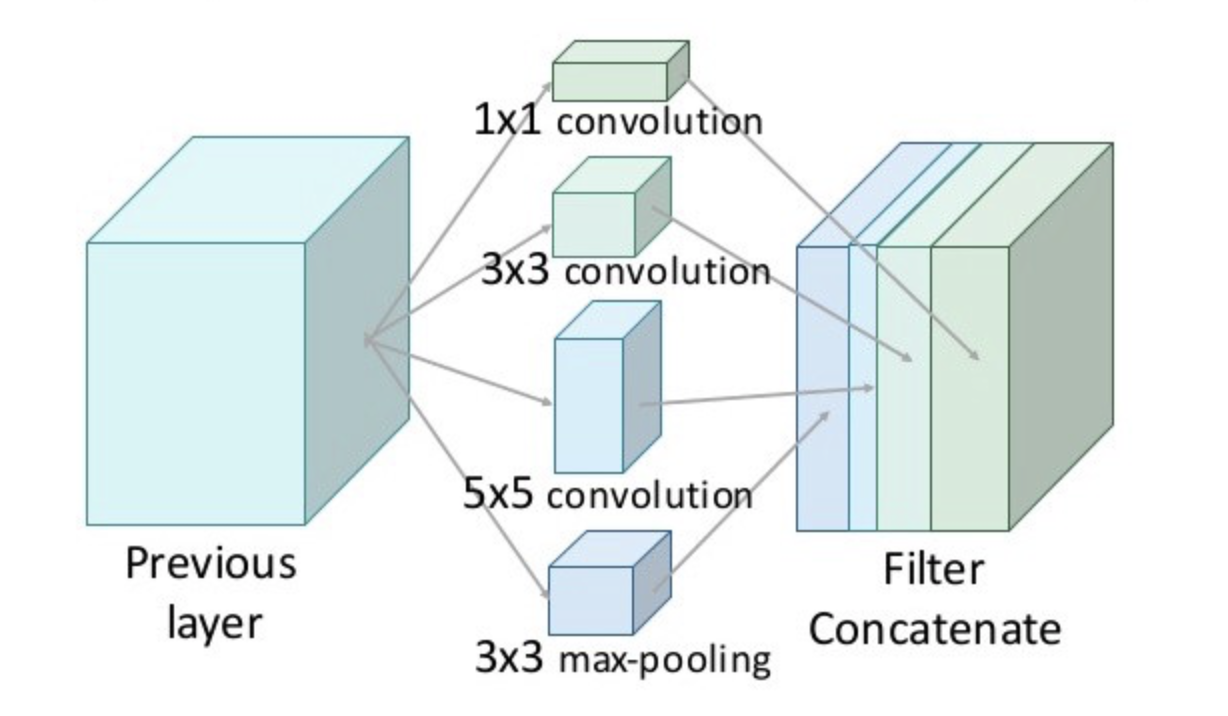

Это позволяет сети научиться извлекать различные уровни абстракции изображений, начиная от более низкоуровневых (локальных) признаков и заканчивая более высокоуровневыми (глобальными) признаками.

Другой ключевой компонент - это "батч-нормализация" (batch normalization), которая помогает стабилизировать обучение сети, ускоряя сходимость и уменьшая вероятность переобучения.

Также Inception-v3 включает "свертки с расширением" (1x1 convolution), которые служат для уменьшения размерности перед более глубокими слоями. Это позволяет снизить количество параметров и вычислительную сложность сети.

В конце архитектуры используется "глобальное среднее пулингование" (global average pooling), которое позволяет усреднить признаки на всем изображении, получив компактное представление, и использовать его для классификации или других задач.

Принцип работы Inception-v3 заключается в эффективном объединении различных видов операций свертки и пулинга для извлечения богатых иерархических признаков из изображений, что позволяет достигать высокой точности классификации и детектирования объектов при относительно небольшой вычислительной нагрузке.

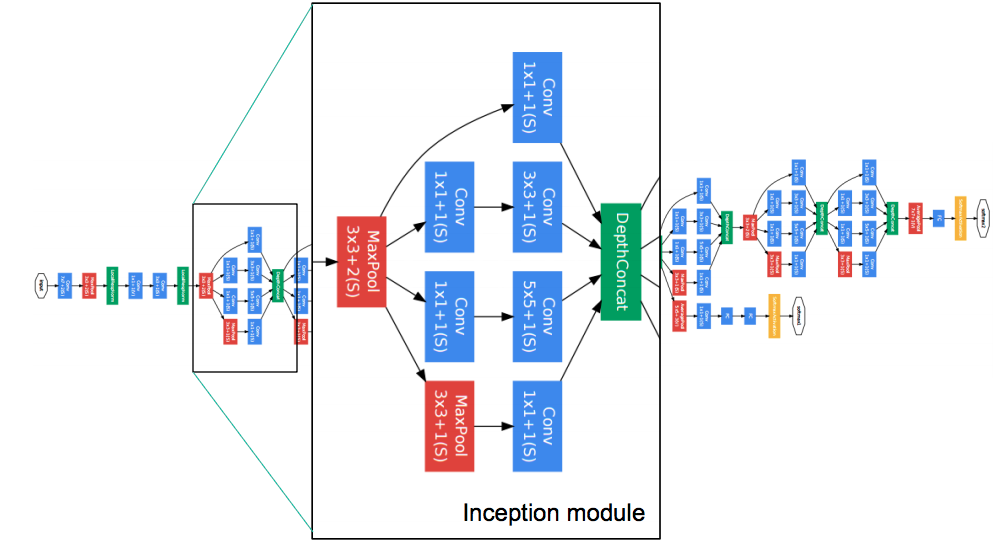

In [ ]:
class Classifier:

    def __init__(self, learning_rate=0.03, num_epochs=10, device= device, model=None):
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.device = torch.device(device)
        self.model = model.to(self.device) if model is not None else None
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=self.learning_rate)
        self.train_loss = []
        self.test_loss = []
        self.train_accuracy = []
        self.test_accuracy = []

    def evaluate_accuracy(self, data_loader, net):
        acc_sum, n = 0, 0
        net.eval()
        for X, y in data_loader:
            X, y = X.to(self.device), y.to(self.device)
            acc_sum += (net(X).argmax(axis=1) == y).sum().item()
            n += y.shape[0]
        return acc_sum / n

    def evaluate_loss(self, data_loader, net):
        running_loss = 0.0
        for X, y in data_loader:
            X, y = X.to(self.device), y.to(self.device)
            outputs = self.model(X)
            loss = self.criterion(outputs[0], y)
            running_loss += loss.item()
        return round(running_loss/len(data_loader),4)

    def fit(self, train_loader, test_loader):
        for epoch in range(self.num_epochs):
            self.model.train()
            running_loss = 0.0
            start = time.time()

            for i, data in enumerate(train_loader, 0):
                inputs, labels = data
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs[0], labels)
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item()
                print(f"\r{(int(i/len(train_loader)*100))+1}% ", end="", flush=True)

            self.train_loss.append(round(running_loss/len(train_loader), 4))
            loss_tst = self.evaluate_loss(test_loader, self.model)
            self.test_loss.append(loss_tst)

            test_acc = self.evaluate_accuracy(test_loader, self.model)
            train_acc = self.evaluate_accuracy(train_loader, self.model)
            self.train_accuracy.append(round(train_acc,3))
            self.test_accuracy.append(round(test_acc,3))


            print(f"Epoch: [{epoch+1}/{self.num_epochs}],Time: {time.time() - start:.1f}sec.,"
            f" Train loss:{running_loss/len(train_loader):.4f},Train accuracy: {train_acc:.3f},"
            f"Test loss : {loss_tst}, Test accuracy: {test_acc:.3f}")

            torch.cuda.empty_cache()

    def predict(self, test_loader):
        self.model.eval()
        predictions = []
        with torch.no_grad():
            for data in test_loader:
                inputs, _ = data
                inputs = inputs.to(self.device)
                outputs = self.model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                predictions.extend(predicted.cpu().numpy())
        return predictions


In [ ]:
transoforms = tv.transforms.Compose([
    tv.transforms.Grayscale(3),
    tv.transforms.Resize((299, 299)),
    tv.transforms.ToTensor()
])
train_dataset = tv.datasets.EMNIST('.', train=True, transform=transoforms, download=True, split='mnist')
test_dataset = tv.datasets.EMNIST('.', train=False, transform=transoforms, download=True, split='mnist')

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16)

In [ ]:
model_inception_v3 = tv.models.inception_v3(pretrained= False)

In [ ]:
model_inception_v3

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
model_inception_v3.fc = nn.Linear(in_features=2048, out_features=10)

In [ ]:
clf_inception_v3 = Classifier(model = model_inception_v3)

In [ ]:
clf_inception_v3.fit(train_loader, test_loader)

100% Epoch: [1/10],Time: 1348.6sec., Train loss:0.2450,Train accuracy: 0.991,Test loss : 0.0631, Test accuracy: 0.990
100% Epoch: [2/10],Time: 1340.2sec., Train loss:0.0538,Train accuracy: 0.994,Test loss : 0.0427, Test accuracy: 0.993
100% Epoch: [3/10],Time: 1338.3sec., Train loss:0.0354,Train accuracy: 0.996,Test loss : 0.0326, Test accuracy: 0.994
100% Epoch: [4/10],Time: 1336.7sec., Train loss:0.0225,Train accuracy: 0.997,Test loss : 0.0291, Test accuracy: 0.995
100% Epoch: [5/10],Time: 1335.1sec., Train loss:0.0139,Train accuracy: 0.998,Test loss : 0.0285, Test accuracy: 0.995
100% Epoch: [6/10],Time: 1339.2sec., Train loss:0.0081,Train accuracy: 0.999,Test loss : 0.0237, Test accuracy: 0.996
100% Epoch: [7/10],Time: 1338.1sec., Train loss:0.0044,Train accuracy: 0.999,Test loss : 0.0245, Test accuracy: 0.996
100% Epoch: [8/10],Time: 1335.7sec., Train loss:0.0024,Train accuracy: 0.999,Test loss : 0.0236, Test accuracy: 0.996
100% Epoch: [9/10],Time: 1338.8sec., Train loss:0.0013,T

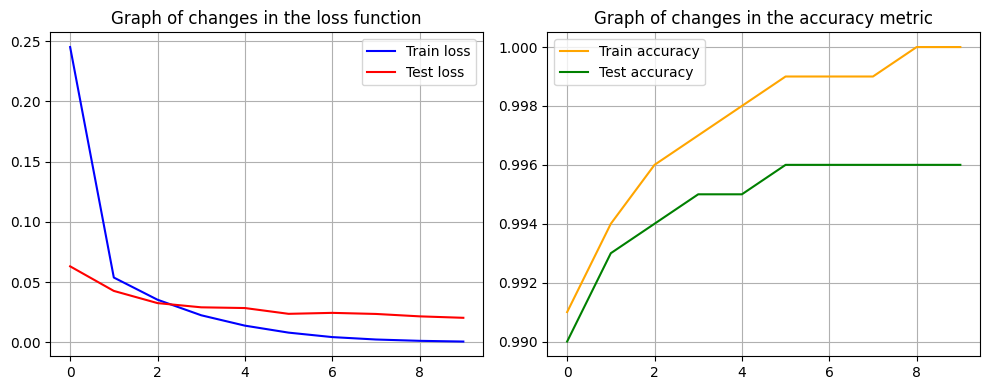

In [ ]:
Graph_metrics(clf_inception_v3)

#Итог

In [ ]:
df = pd.DataFrame({'number epoch':[1,2,3,4,5,6,7,8,9,10]
                   'ResNet18 train loss':clf_resnet18.train_loss,
                   'ResNet18 test loss':clf_resnet18.test_loss,
                   'ResNet18 train accuracy':clf_resnet18.train_accuracy,
                   'ResNet18 test accuracy':clf_resnet18.test_accuracy,
                   'VGG16 train loss':clf_VGG16.train_loss,
                   'VGG16 test loss':clf_VGG16.test_loss,
                   'VGG16 train accuracy':0.985,
                   'VGG16 test accuracy':0.984,
                   'DenseNet161 train loss':clf_densenet161.train_loss,
                   'DenseNet161 test loss':clf_densenet161.test_loss,
                   'DenseNet161 train accuracy':clf_densenet161.train_accuracy,
                   'DenseNet161 test accuracy':clf_densenet161.test_accuracy,
                   'Inception_v3 train loss':clf_inception_v3.train_loss,
                   'Inception_v3 test loss':clf_inception_v3.test_loss,
                   'Inception_v3 train accuracy':clf_inception_v3.train_accuracy,
                   'Inception_v3 test accuracy':clf_inception_v3.test_accuracy,
                   })

In [ ]:
df

,number epoch,ResNet18 train loss,ResNet18 test loss,ResNet18 train accuracy,ResNet18 test accuracy,VGG16 train loss,VGG16 test loss,VGG16 train accuracy,VGG16 test accuracy,DenseNet161 train loss,DenseNet161 test loss,DenseNet161 train accuracy,DenseNet161 test accuracy,Inception_v3 train loss,Inception_v3 test loss,Inception_v3 train accuracy,Inception_v3 test accuracy
0,1,0.1350,0.0391,0.992,0.991,0.2522,0.0424,0.990,0.990,0.1615,0.0443,0.993,0.992,0.2450,0.0631,0.991,0.990
1,2,0.0310,0.0245,0.996,0.994,0.0411,0.0310,0.994,0.993,0.0347,0.0288,0.995,0.994,0.0538,0.0427,0.994,0.993
2,3,0.0159,0.0197,0.998,0.995,0.0273,0.0342,0.995,0.992,0.0189,0.0229,0.997,0.996,0.0354,0.0326,0.996,0.994
3,4,0.0080,0.0179,0.999,0.996,0.0204,0.0309,0.996,0.994,0.0095,0.0209,0.998,0.996,0.0225,0.0291,0.997,0.995
4,5,0.0036,0.0176,0.999,0.995,0.0163,0.0267,0.998,0.994,0.0046,0.0201,0.999,0.996,0.0139,0.0285,0.998,0.995
5,6,0.0013,0.0183,1.000,0.995,0.0137,0.0321,0.998,0.994,0.0021,0.0204,0.999,0.996,0.0081,0.0237,0.999,0.996
6,7,0.0006,0.0182,1.000,0.995,0.0101,0.0324,0.999,0.995,0.0009,0.0192,1.000,0.997,0.0044,0.0245,0.999,0.996
7,8,0.0004,0.0181,1.000,0.995,0.0099,0.0278,0.999,0.995,0.0005,0.0191,1.000,0.997,0.0024,0.0236,0.999,0.996
8,9,0.0003,0.0182,1.000,0.996,0.0070,0.0390,0.997,0.992,0.0003,0.0190,1.000,0.997,0.0013,0.0216,1.000,0.996
9,10,0.0002,0.0182,1.000,0.995,0.0075,0.0282,0.998,0.993,0.0003,0.0191,1.000,0.997,0.0007,0.0204,1.000,0.996


In [ ]:
def res_plot(metrix):
    plt.plot( df[f'DenseNet161 {metrix}'], 'o-r', label='densenet161', linestyle='--')
    plt.plot(df[f'ResNet18 {metrix}'], 'o-r', label='resnet18', linestyle='--')
    plt.plot(df[f'VGG16 {metrix}'],'o-.g', label='vgg16', linestyle='--')
    plt.plot(df[f'Inception_v3 {metrix}'],'o-.y', label='inception_v3', linestyle='--')
    plt.legend()
    plt.title(f'{metrix}')
    plt.show()

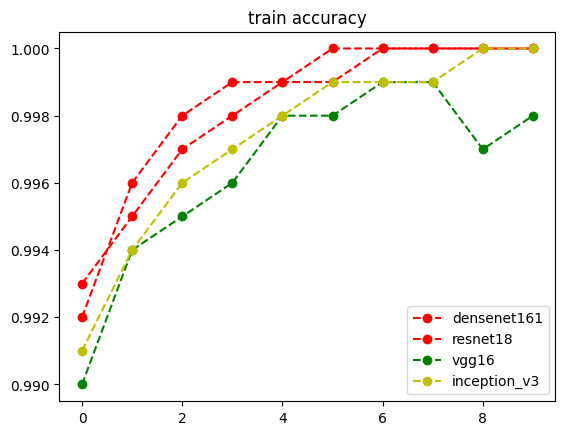

In [ ]:
res_plot('train accuracy')

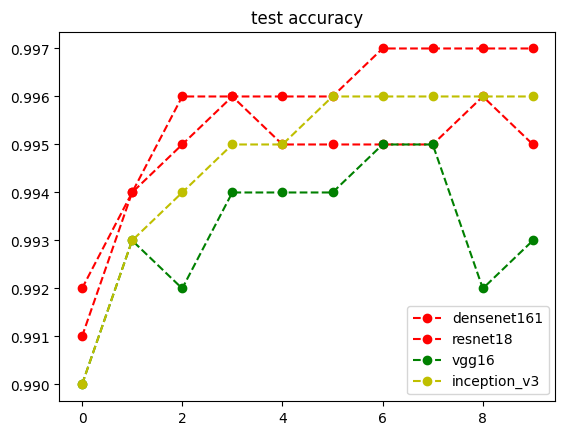

In [ ]:
res_plot('test accuracy')

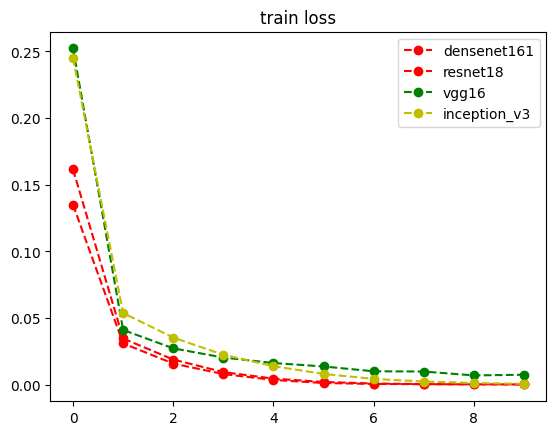

In [ ]:
res_plot('train loss')

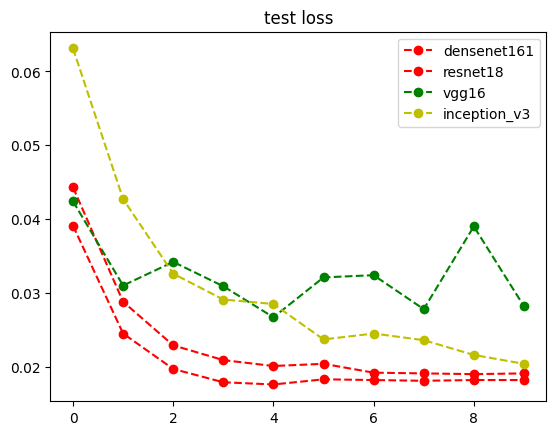

In [ ]:
res_plot('test loss')